In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
from torchmetrics.functional import accuracy

In [3]:
from PIL import Image
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc
from sklearn.model_selection import train_test_split

In [4]:
# Hyper params
epochs = 10
batch_size = 64
learing_rate = 1e-4
eps = 1e-8

# Build Simple CNN

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128 * 1 * 1, 256),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(256, 29)
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        return self.classifier(features)

In [6]:
model = SimpleCNN()
model.to('cuda')

SimpleCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=29, bias=True)
  )
)

# Lets load data

In [7]:
labels = sorted([os.path.basename(folder_path) for folder_path in glob.glob('data/asl_alphabet_train/asl_alphabet_train/*')])
labels_index = dict([(label, index) for index, label in enumerate(labels)])
index_labels = dict([(index, label) for index, label in enumerate(labels)])

In [8]:
image_files = glob.glob('data/asl_alphabet_train/asl_alphabet_train/**/*.jpg', recursive=True)

In [9]:
# Split dataset
train_images, test_images = train_test_split(image_files, test_size=0.2, random_state=2021)

# Prepare data

In [10]:
class HandSignDataset(Dataset):
    def __init__(self, image_list, labels_index):
        super(HandSignDataset, self).__init__()
        self.image_list = image_list
        self.labels_index = labels_index
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image_path = self.image_list[index]
    
        base_path = os.path.basename(os.path.dirname(image_path))
        label = self.labels_index[base_path]
        
        img = Image.open(image_path)
        img = img.resize((224, 224))
        img = np.array(img).transpose(2, 1 ,0)
        
        img = img / 255.
        img = torch.tensor(img, dtype=torch.float32)
        
        return img, label

In [11]:
train_dataset = HandSignDataset(train_images, labels_index)
test_dataset = HandSignDataset(test_images, labels_index)

In [12]:
# Load into dataloader
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size, num_workers=6)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size, num_workers=6)

# Train model

In [13]:
# Load optim and loss function
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=learing_rate, eps=eps)

In [14]:
for epoch in tqdm(range(epochs)):
    model.train()
    training_loss = 0
    
    for step, (train_image, train_label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        train_batch_image = train_image.to('cuda')
        train_batch_label = train_label.to('cuda')
        
        # Forward pass
        optim.zero_grad()
        logits = model(train_batch_image)
        
        # Backward pass
        loss = criterion(logits, train_batch_label)
        loss.backward()
        training_loss += loss.item()
        
        optim.step()
        
    print('[Epoch %d] Training loss: %.3f' %(epoch + 1, training_loss/ len(train_dataloader)))
    
    model.eval()
    preds = []
    targets = []
    
    test_loss = 0
    for step, (test_image, test_labels) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        test_batch_image = test_image.to('cuda')
        test_batch_label = test_labels.to('cuda')
        targets.append(test_labels)
        
        with torch.no_grad():
            logits = model(test_batch_image)
        
        loss = criterion(logits, test_batch_label)
        test_loss += loss.item()
        
        preds.append(logits.detach().cpu().numpy().argmax(axis=1))
    
    preds = torch.tensor(np.concatenate(preds))
    targets = torch.tensor(np.concatenate(targets))
    print('[Epoch %d] Test loss: %.3f' %(epoch + 1, test_loss/ len(test_dataloader)))
    print('Accuracy: {}%'.format(round(accuracy(target=targets, preds=preds).item() * 100), 2))


[Epoch 1] Training loss: 3.287



[Epoch 1] Test loss: 3.151
Accuracy: 8



[Epoch 2] Training loss: 3.080



[Epoch 2] Test loss: 3.005
Accuracy: 12



[Epoch 3] Training loss: 2.958



[Epoch 3] Test loss: 2.873
Accuracy: 13



[Epoch 4] Training loss: 2.875



[Epoch 4] Test loss: 2.807
Accuracy: 14



[Epoch 5] Training loss: 2.810



[Epoch 5] Test loss: 2.739
Accuracy: 16



[Epoch 6] Training loss: 2.738



[Epoch 6] Test loss: 2.665
Accuracy: 17



[Epoch 7] Training loss: 2.659



[Epoch 7] Test loss: 2.582
Accuracy: 19



[Epoch 8] Training loss: 2.553



[Epoch 8] Test loss: 2.453
Accuracy: 22



[Epoch 9] Training loss: 2.399



[Epoch 9] Test loss: 2.297
Accuracy: 27



[Epoch 10] Training loss: 2.225



[Epoch 10] Test loss: 2.089
Accuracy: 35



# Evaluate Model

In [15]:
model.eval()

preds = []
targets = []
for step, (test_image, test_labels) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    targets.append(test_labels)
    with torch.no_grad():
        test_batch_image = test_image.to('cuda')
        logits = model(test_batch_image)
        
        preds.append(logits.detach().cpu().numpy().argmax(axis=1))
    
preds = np.concatenate(preds)
targets = np.concatenate(targets)

In [16]:
print(classification_report(targets, preds, target_names=labels))

              precision    recall  f1-score   support

           A       0.27      0.51      0.35       631
           B       0.50      0.27      0.35       582
           C       0.45      0.46      0.46       574
           D       0.56      0.29      0.39       603
           E       0.15      0.16      0.16       631
           F       0.44      0.55      0.49       597
           G       0.49      0.45      0.47       624
           H       0.43      0.77      0.55       560
           I       0.34      0.34      0.34       605
           J       0.43      0.49      0.46       554
           K       0.39      0.26      0.31       584
           L       0.50      0.41      0.45       598
           M       0.27      0.26      0.27       615
           N       0.28      0.32      0.30       586
           O       0.31      0.37      0.34       590
           P       0.64      0.64      0.64       597
           Q       0.38      0.48      0.42       610
           R       0.22    

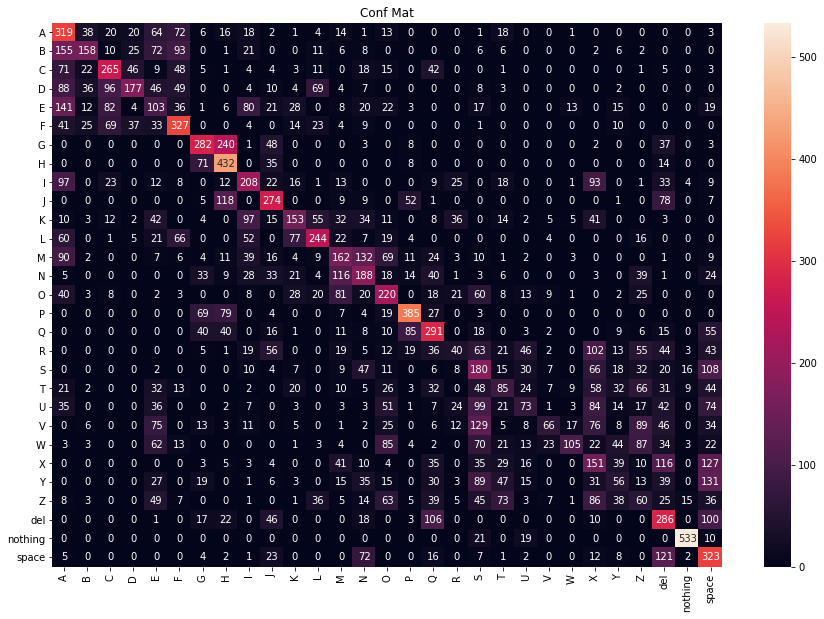

In [17]:
plt.figure(figsize=(15, 10))
plt.title('Conf Mat')
sns.heatmap(
    confusion_matrix(targets, preds), fmt='d', annot=True,
    xticklabels=labels, yticklabels=labels
);

In [18]:
print('MCC: {}'.format(round(matthews_corrcoef(targets, preds) * 100, 2)))

MCC: 33.14
